# Using _bossphorus_ without intern

You may choose to use _bossphorus_ without installing intern (`pip install intern`): In this case, you can manually write your POST and GET functions.

In [1]:
%matplotlib inline

import requests
import numpy as np
import matplotlib.pyplot as plt
import blosc
import io

## Setup

First, create some dummy data:

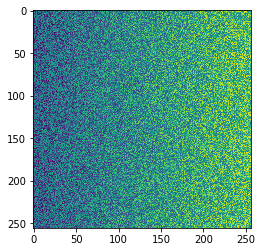

In [2]:
data = np.random.randint(0, 100, (256, 256, 256), dtype="uint8")
for i in range(data.shape[0]):
    data[i] += int(i/4)
for j in range(data.shape[2]):
    data[:,:,j] += int(j/4)
plt.imshow(data[0])

## POST and GET functions

Here are the recommended functions to use with _bossphorus_ running on localhost on port 5000.

In [3]:
def post_data(data, col, exp, chan, origin=[0, 0, 0]):
    res = requests.post("http://localhost:5000/cutout/upload/{}/{}/{}/0/{}:{}/{}:{}/{}:{}/".format(
        col, exp, chan, 
        origin[0], origin[0] + data.shape[0],
        origin[1], origin[1] + data.shape[1],
        origin[2], origin[2] + data.shape[2]
    ), files={
        'file': data.tobytes()
    })
    return res

def get_data(col, exp, chan, xs, ys, zs):
    res = requests.get(
        "http://localhost:5000/v1/cutout/{}/{}/{}/0/{}:{}/{}:{}/{}:{}/".format(
            col, exp, chan, xs[0], xs[1], ys[0], ys[1], zs[0], zs[1]
        ),
    )
    if res.status_code in [200, 201]:
        return np.fromstring(
            blosc.decompress(res._content), dtype="uint8"
        ).reshape(
            zs[1] - zs[0], 
            ys[1] - ys[0], 
            xs[1] - xs[0]
        ).transpose()
    else:
        return res.json()

## Tests

Validate that we're doing what we say we're doing

In [5]:
post_data(data[:130, :64, :126], "cc", "ee", "ch")

def test_subindex():
    newdata = get_data("cc", "ee", "ch", [0, 10], [0, 10], [0, 10])
    assert (newdata == data[:10, :10, :10]).all()
    print("Passed:\ttest_subindex")

def test_get_full_file():
    newdata = get_data("cc", "ee", "ch", [0, 200], [0, 70], [0, 70])
    assert (newdata[:128, :50, :50] == data[:128, :50, :50]).all()
    print("Passed:\ttest_get_full_file")

def test_zeros_outside_dataset():
    newdata = get_data("cc", "ee", "ch", [1000, 1005], [0, 6], [0, 6])
    assert (np.sum(newdata) == 0)
    print("Passed:\ttest_zeros_outside_dataset")
    
tests = [i() for i in
    [
        test_subindex,
        test_get_full_file,
        test_zeros_outside_dataset
    ]
]

Passed:	test_subindex
Passed:	test_get_full_file
Passed:	test_zeros_outside_dataset


/usr/local/lib/python3.6/site-packages/ipykernel_launcher.py:20: DeprecationWarning: The binary mode of fromstring is deprecated, as it behaves surprisingly on unicode inputs. Use frombuffer instead
